# Extract Job Posts from Indeed

Before extracting job posts from [Indeed](https://www.indeed.com/), make sure you have checked their [robots.txt](https://www.indeed.com/robots.txt) file. 

## Create a table in database

In [1]:
import pandas
import configparser
import psycopg2

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Read the database connection info from the config.ini

In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['myaws']['host']
db = config['myaws']['db']
user = config['myaws']['user']
pwd = config['myaws']['pwd']

Establish a connection to the databas, and create a cursor.

In [3]:
conn = psycopg2.connect(host = host,
                       user = user,
                        password = pwd,
                        dbname = db
                       )
cur = conn.cursor()

Design the table in SQL

In [4]:
# replace the schema and table name to your schema and table name
table_sql = """
            CREATE TABLE IF NOT EXISTS demo.indeed
            (
                id SERIAL,
                job_title VARCHAR(200),
                job_company VARCHAR(200),
                job_loc VARCHAR(200),
                job_salary VARCHAR(200),
                job_summary TEXT,
                PRIMARY KEY(id)
            );

            """

create the table

In [5]:
cur.execute(table_sql)
conn.commit()

## Request HTML

[urllib.request](https://docs.python.org/3/library/urllib.request.html) makes simple HTTP requests to visit a web page and get the content via the Python standard library.
Here we define the URL to search job pots about Intelligence analyst.

In [23]:
url = 'https://www.indeed.com/jobs?q=intelligence+analyst&start=2'

In [24]:
import urllib.request
response = urllib.request.urlopen(url)
html_data= response.read()
#print(html_data.decode('utf-8'))

# Parese HTML
We can use the inspector tool in browsers to analyze webpages and use [beautifulsoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to extract webpage data.
pip install the beautiful soup if needed. 

In [ ]:
!pip install beautifulsoup4

In [25]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html_data,'html.parser')
#print (soup)

Use the <code> tag.find_all(‘tag_name’, tage_attr = ‘possible_value’)</code> function to return a list of tags where the attribute equals the possible_value.
<ul>Common attributes include:
<li> id</li>
<li> class<span style ="color:red">_</span></li>
</ul>

<ul>Common functions include:
<li> tag.text: return the visible part of the tag</li>
<li> tag.get(‘attribute’): return the value of the attribute of the tag</li>
</ul>

Since all the job posts are in the <code>div tag class = 'jobsearch-Sprep...'</code>, we need to find that div tag from the body tag.

In [26]:
for table_resultsBody in soup.find_all('table', id = 'resultsBody'):
    pass
    #print(table_resultsBody)

In [27]:
for table_pageContent in table_resultsBody.find_all('table', id = 'pageContent'):
    pass
    #print(table_pageContent)

In [28]:
for td_resultsCol in table_pageContent.find_all('td', id = 'resultsCol'):
    pass
    #print(td_resultsCol)

## Save Data to Database
Now we find the div tag contains the job posts. We need to identify the job title, company, ratings, reviews, salary, and summary. 
We can save those records to our table in the database.

In [29]:
#  identify the job title, company, ratings, reviews, salary, and summary
for div_row in td_resultsCol.find_all('div', class_='jobsearch-SerpJobCard unifiedRow row result'):

    # find job title
    job_title = None
    job_company  = None
    job_rating = None
    job_loc = None
    job_salary = None
    job_summary = None
    for h2_title in div_row.find_all('h2', class_ = 'title'):
       
        job_title = h2_title.a.text.strip().replace("'","_")
   
    for div_dsc in div_row.find_all('div', class_ = 'sjcl'):
        
        #find company name
        for span_company in div_dsc.find_all('span', class_ = 'company'):
            job_company = span_company.text.strip().replace("'","_")
        
        # find location
        for div_loc in div_dsc.find_all('div', class_ = 'location accessible-contrast-color-location'):
            job_loc = div_loc.text.strip().replace("'","_")
    
    # find salary
    for div_salary in div_row.find_all('div',class_ ='salarySnippet'):
        job_salary = div_salary.text.strip().replace("'","_")
    
    #find summary
    for div_summary in div_row.find_all('div', class_ = 'summary'):
        job_summary = div_summary.text.strip().replace("'","_")
        
    # insert into database
    
    sql_insert = """
                insert into demo.indeed(job_title,job_company,job_loc,job_salary,job_summary)
                values('{}','{}','{}','{}','{}')            
                """.format(job_title,job_company,job_loc,job_salary,job_summary)

    cur.execute(sql_insert)
    conn.commit()

## Query the Table

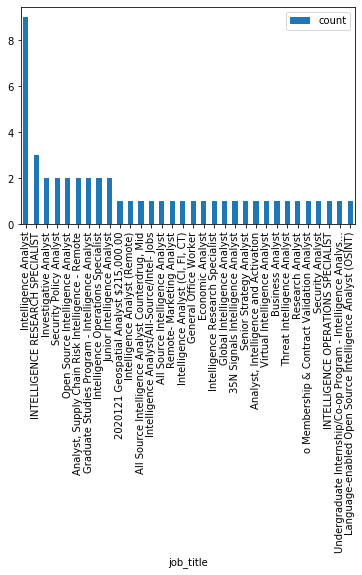

In [50]:
df = pandas.read_sql_query('select count(*) as count,job_title from demo.indeed group by job_title order by count desc ', conn)
df.plot.bar(x='job_title')

In [51]:
cur.close()
conn.close()